# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_PATH = '/content/drive/MyDrive/CXR_data_UpGrad.zip (Unzipped Files)'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

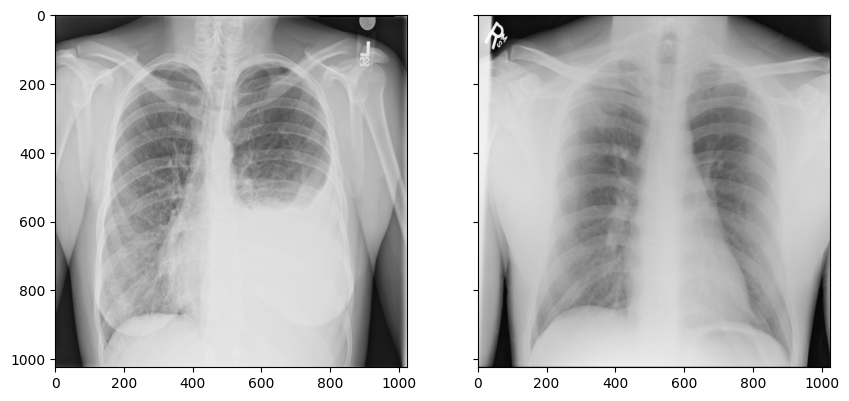

In [4]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[1])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[1])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [5]:
effusion.shape

(1024, 1024)

In [6]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [7]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')

    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously).

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [8]:
import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    add,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    #if K.image_dim_ordering() == 'tf':
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    #else:
    #CHANNEL_AXIS = 1
    #ROW_AXIS = 2
    #COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        # if K.image_dim_ordering() == 'tf':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [9]:
#import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [10]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'],
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode

        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})


        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [11]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=validation_generator)

1/1 [==============================] - 15s 15s/step - loss: 1.7527 - accuracy: 0.2500


In [12]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 11s 11s/step - loss: 1.4428 - accuracy: 0.8710
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 1.3329 - accuracy: 0.9355
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 1.3214 - accuracy: 0.9032
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 1.3398 - accuracy: 0.8750
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 1.2928 - accuracy: 0.9032


In [13]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [14]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
1/1 [==============================] - 0s 372ms/step

Val AUC for epoch0: 0.19540229885057472
5/5 [==============================] - 107s 20s/step - loss: 1.6121 - accuracy: 0.6516 - val_loss: 1.2665 - val_accuracy: 0.9375 - val_auc: 0.1954
Epoch 2/5
1/1 [==============================] - 0s 25ms/step

Val AUC for epoch1: 0.43333333333333335
5/5 [==============================] - 25s 5s/step - loss: 1.2957 - accuracy: 0.9026 - val_loss: 1.4980 - val_accuracy: 0.9062 - val_auc: 0.4333
Epoch 3/5
1/1 [==============================] - 0s 26ms/step

Val AUC for epoch2: 0.25
5/5 [==============================] - 16s 3s/step - loss: 1.2918 - accuracy: 0.8968 - val_loss: 1.2153 - val_accuracy: 0.9375 - val_auc: 0.2500
Epoch 4/5
1/1 [==============================] - 0s 21ms/step

Val AUC for epoch3: 0.2873563218390805
5/5 [==============================] - 13s 3s/step - loss: 1.2980 - accuracy: 0.8903 - val_loss: 1.4042 - val_accuracy: 0.8750 - val_auc: 0.2874
Epoch 5/5
1/1 [======

In [15]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [16]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

1/1 [==============================] - 8s 8s/step - loss: 1.9753 - accuracy: 0.8750


In [17]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
1/1 [==============================] - 0s 309ms/step

Val AUC for epoch0: 0.3035714285714286
5/5 [==============================] - 21s 3s/step - loss: 1.9226 - accuracy: 0.8831 - val_loss: 10.3291 - val_accuracy: 0.0625 - val_auc: 0.3036
Epoch 2/5
1/1 [==============================] - 0s 22ms/step

Val AUC for epoch1: 0.5333333333333333
5/5 [==============================] - 14s 3s/step - loss: 1.8510 - accuracy: 0.8896 - val_loss: 3.0593 - val_accuracy: 0.5938 - val_auc: 0.5333
Epoch 3/5
1/1 [==============================] - 0s 21ms/step

Val AUC for epoch2: 0.033333333333333326
5/5 [==============================] - 17s 4s/step - loss: 1.9089 - accuracy: 0.8896 - val_loss: 1.6755 - val_accuracy: 0.9375 - val_auc: 0.0333
Epoch 4/5
1/1 [==============================] - 0s 28ms/step

Val AUC for epoch3: 0.27586206896551724
5/5 [==============================] - 13s 3s/step - loss: 1.8421 - accuracy: 0.8896 - val_loss: 2.9604 - val_accuracy: 0.5938 - val_auc: 0.2759
Epoch 5

## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [18]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []

    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [20]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=100)
validation_generator = AugmentedDataGenerator('val', ablation=100)

auc_logger = roc_callback()
filepath = '/content/drive/MyDrive/CXR_data_UpGrad.zip (Unzipped Files)/trined_model/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=50, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/50
1/1 [==============================] - 0s 23ms/step

Val AUC for epoch0: 0.5403103133556435

Epoch 1: val_auc improved from -inf to 0.54031, saving model to /content/drive/MyDrive/CXR_data_UpGrad.zip (Unzipped Files)/trined_model/best_model.hdf5
27/27 [==============================] - 86s 3s/step - loss: 2.2530 - accuracy: 0.5215 - val_loss: 2.3033 - val_accuracy: 0.3177 - val_auc: 0.5403
Epoch 2/50
1/1 [==============================] - 0s 24ms/step

Val AUC for epoch1: 0.5386334610472542

Epoch 2: val_auc did not improve from 0.54031
27/27 [==============================] - 74s 3s/step - loss: 2.2231 - accuracy: 0.5737 - val_loss: 2.2751 - val_accuracy: 0.2500 - val_auc: 0.5386
Epoch 3/50
1/1 [==============================] - 0s 23ms/step

Val AUC for epoch2: 0.5287394957983194

Epoch 3: val_auc did not improve from 0.54031
27/27 [==============================] - 74s 3s/step - loss: 2.0794 - accuracy: 0.6719 - val_loss: 2.4057 - val_accuracy: 0.0990 - val_auc: 0.5287
Ep

## 5. Making a Prediction

In [21]:
val_model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('/content/drive/MyDrive/CXR_data_UpGrad.zip (Unzipped Files)/trined_model/best_model.hdf5')

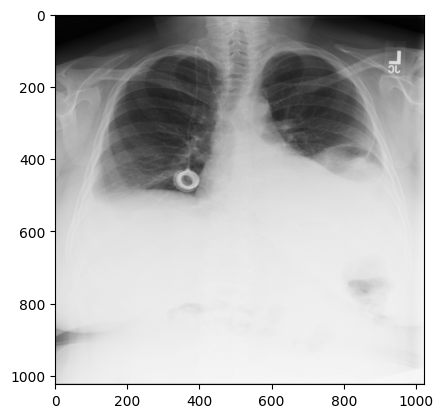

In [30]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-10])
plt.imshow(effusion,cmap='gray')

In [31]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

1/1 [==============================] - 0s 18ms/step


array([[0.28125185, 0.7187482 ]], dtype=float32)

**Model Predicted x-ray image belongs to efussion class with 72% confidence**